In [ ]:
# Future annotations
from __future__ import annotations

# Standard library
import os
import time
import math
import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, Optional, Union

# Third-party: scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Third-party: PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Third-party: Torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision import transforms
from torchvision import models

# Third-party: Data loading / utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch


# Third-party: Metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Third-party: Imaging
from PIL import Image

from pathlib import Path
from typing import Optional, Union

import numpy as np
import pandas as pd
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
CSV_DIR = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact")

# исходники
train_align_csv = CSV_DIR / "train_align_112.csv"
val_align_csv   = CSV_DIR / "val_align_112.csv"
test_align_csv  = CSV_DIR / "test_align_112.csv"

train_thin_csv  = CSV_DIR / "train_thin.csv"
val_thin_csv    = CSV_DIR / "val_thin.csv"
test_thin_csv   = CSV_DIR / "test_thin.csv"

# куда сохранить
out_train_csv = CSV_DIR / "train_recognition_112.csv"
out_val_csv   = CSV_DIR / "val_recognition_112.csv"
out_test_csv  = CSV_DIR / "test_recognition_112.csv"


In [ ]:
def build_recognition_df(align_csv: Path, thin_csv: Path) -> pd.DataFrame:
    df_align = pd.read_csv(align_csv)
    df_thin  = pd.read_csv(thin_csv)

    # sanity: нужные колонки
    for c in ["image_id", "aligned_path"]:
        if c not in df_align.columns:
            raise KeyError(f"{align_csv.name}: missing column '{c}'")
    for c in ["image_id", "label"]:
        if c not in df_thin.columns:
            raise KeyError(
                f"{thin_csv.name}: missing column '{c}'. "
                f"Columns are: {df_thin.columns.tolist()}"
            )

    df_a = df_align[["image_id", "aligned_path"]].copy()
    df_t = df_thin[["image_id", "label"]].copy()

    # merge
    df = df_a.merge(df_t, on="image_id", how="inner")

    # базовые проверки
    if len(df) != len(df_a):
        miss = len(df_a) - len(df)
        raise ValueError(
            f"Merge mismatch for {align_csv.name}: got {len(df)} rows, expected {len(df_a)}. "
            f"Missing labels for {miss} images."
        )

    df["label"] = df["label"].astype(int)
    return df


In [ ]:
def print_class_stats(df: pd.DataFrame, name: str = "train") -> None:
    vc = df["label"].value_counts()
    print(f"\n===== {name} class stats =====")
    print("num_samples:", len(df))
    print("num_classes:", vc.shape[0])
    print("min/median/mean/max per class:",
          int(vc.min()),
          float(vc.median()),
          float(vc.mean()),
          int(vc.max()))
    print("\nTop-10 biggest classes:\n", vc.head(10))
    print("\nTop-10 smallest classes:\n", vc.tail(10))


In [ ]:
# Собираем DFs
df_train = build_recognition_df(train_align_csv, train_thin_csv)
df_val   = build_recognition_df(val_align_csv,   val_thin_csv)
df_test  = build_recognition_df(test_align_csv,  test_thin_csv)

# Перекодируем label в 0..C-1 (единая кодировка по train)
# mapping: original_label -> new_label
uniq_train_labels = sorted(df_train["label"].unique().tolist())
label2idx = {lab: i for i, lab in enumerate(uniq_train_labels)}


In [ ]:
def map_labels(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    # проверяем, что в val/test нет "новых" людей (иначе ArcFace head не совпадёт)
    unknown = sorted(set(df["label"].unique()) - set(label2idx.keys()))
    if unknown:
        raise ValueError(
            f"{split_name}: found labels not present in train ({len(unknown)} labels). "
            f"Example: {unknown[:10]}"
        )
    df = df.copy()
    df["label"] = df["label"].map(label2idx).astype(int)
    return df



In [ ]:
df_train = map_labels(df_train, "train")
df_val   = map_labels(df_val,   "val")
df_test  = map_labels(df_test,  "test")



In [ ]:
# Проверяем распределение классов
print_class_stats(df_train, "train")
print_class_stats(df_val,   "val")
print_class_stats(df_test,  "test")



===== train class stats =====
num_samples: 10070
num_classes: 700
min/median/mean/max per class: 14 14.0 14.385714285714286 15

Top-10 biggest classes:
 label
184    15
263    15
559    15
455    15
366    15
137    15
180    15
81     15
473    15
79     15
Name: count, dtype: int64

Top-10 smallest classes:
 label
104    14
647    14
543    14
265    14
174    14
672    14
616    14
630    14
561    14
145    14
Name: count, dtype: int64

===== val class stats =====
num_samples: 2518
num_classes: 700
min/median/mean/max per class: 3 4.0 3.597142857142857 4

Top-10 biggest classes:
 label
691    4
635    4
592    4
26     4
481    4
316    4
478    4
395    4
17     4
64     4
Name: count, dtype: int64

Top-10 smallest classes:
 label
644    3
488    3
631    3
611    3
95     3
521    3
447    3
212    3
25     3
535    3
Name: count, dtype: int64

===== test class stats =====
num_samples: 1399
num_classes: 700
min/median/mean/max per class: 1 2.0 1.9985714285714287 2

Top-10 bigges

In [ ]:
# 4) Сохраняем recognition CSV
df_train.to_csv(out_train_csv, index=False)
df_val.to_csv(out_val_csv, index=False)
df_test.to_csv(out_test_csv, index=False)

print("\nSaved:")
print(out_train_csv)
print(out_val_csv)
print(out_test_csv)




Saved:
/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/train_recognition_112.csv
/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/val_recognition_112.csv
/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/test_recognition_112.csv


In [ ]:
# Быстрая проверка путей
from pathlib import Path
sample_paths = df_train["aligned_path"].sample(5, random_state=42).tolist()
print("\nSample aligned_path exists:")
for p in sample_paths:
    print(Path(p).exists(), p)



Sample aligned_path exists:
True /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/train/197141.jpg
True /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/train/058220.jpg
True /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/train/148307.jpg
True /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/train/060787.jpg
True /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/train/120348.jpg


### ArcFace/CE Dataset + DataLoader

In [ ]:
#  Конфиг
@dataclass
class CFG:
    csv_dir: Path = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1")

    # вставим для красоты, но сейчас мы будем подавать df_train/df_val/df_test напрямую
    train_csv: Path = csv_dir / "train_recognition_112.csv"
    val_csv:   Path = csv_dir / "val_recognition_112.csv"
    test_csv:  Path = csv_dir / "test_recognition_112.csv"

    path_col: str = "aligned_path"
    label_col: str = "label"

    img_size: int = 112
    batch_size: int = 32 # при 64 падает
    num_workers: int = 0 # 2
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()

In [ ]:
class FaceIDAlignedDataset(Dataset):

    def __init__(
        self,
        data: Union[str, Path, pd.DataFrame],
        *,
        path_col: str = "aligned_path",
        label_col: str = "label",
        img_size: int = 112,
        transform,                      # REQUIRED
        strict_files: bool = True,
        check_n: int = 2000,
    ):
        # ---- load df ----
        if isinstance(data, (str, Path)):
            df = pd.read_csv(data)
        else:
            df = data.copy()

        # ---- checks ----
        if path_col not in df.columns:
            raise KeyError(f"Column '{path_col}' not found. Available: {df.columns.tolist()}")
        if label_col not in df.columns:
            raise KeyError(f"Column '{label_col}' not found. Available: {df.columns.tolist()}")

        df = df[[path_col, label_col]].dropna().reset_index(drop=True)

        # labels: enforce int
        df[label_col] = df[label_col].astype("int64")

        # ---- store ----
        self.paths = [str(Path(p)) for p in df[path_col].astype(str).tolist()]
        self.labels = df[label_col].to_numpy(dtype="int64")

        self.img_size = int(img_size)
        self.strict_files = bool(strict_files)

        # ---- transform is mandatory ----
        if transform is None:
            raise ValueError("transform must be provided explicitly (no defaults).")
        self.transform = transform

        # ---- quick file existence check ----
        if self.strict_files and check_n > 0:
            n = min(int(check_n), len(self.paths))
            missing = [p for p in self.paths[:n] if not Path(p).exists()]
            if missing:
                ex = "\n".join(missing[:5])
                raise FileNotFoundError(
                    f"Some files do not exist (showing up to 5):\n{ex}\n"
                    f"Tip: check that '{path_col}' contains correct Colab/Drive paths."
                )

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int):
        img_path = self.paths[idx]
        label = int(self.labels[idx])

        p = Path(img_path)
        if not p.exists():
            if self.strict_files:
                raise FileNotFoundError(f"Image not found: {img_path}")
            img = Image.new("RGB", (self.img_size, self.img_size))
        else:
            img = Image.open(p).convert("RGB")

        x = self.transform(img)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


def make_loader(
    data: Union[pd.DataFrame, str, Path],
    *,
    transform,
    batch_size: int,
    shuffle: bool,
    num_workers: int = 0,
    pin_memory: bool = False,
    strict_files: bool = True,
    drop_last: Optional[bool] = None,
) -> DataLoader:
    if transform is None:
        raise ValueError("transform must be provided explicitly (no defaults).")

    ds = FaceIDAlignedDataset(
        data=data,
        path_col=cfg.path_col,
        label_col=cfg.label_col,
        img_size=cfg.img_size,
        transform=transform,
        strict_files=strict_files,
        check_n=2000,
    )

    if drop_last is None:
        drop_last = bool(shuffle)

    return DataLoader(
        ds,
        batch_size=int(batch_size),
        shuffle=bool(shuffle),
        num_workers=int(num_workers),
        pin_memory=bool(pin_memory),
        drop_last=bool(drop_last),
    )


In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_transforms(img_size: int = 112, *, train_aug: bool = True):

    if train_aug:
        tfm_train = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
            T.RandomGrayscale(p=0.05),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            T.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value="random"),
        ])
    else:
        tfm_train = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

    tfm_val = T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    return tfm_train, tfm_val


In [ ]:
tfm_train, tfm_val = build_transforms(cfg.img_size)

dl_train = make_loader(
    df_train,
    transform=tfm_train,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=(cfg.device == "cuda"),
    strict_files=True,
)

dl_val = make_loader(
    df_val,
    transform=tfm_val,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=(cfg.device == "cuda"),
    strict_files=True,
)

dl_test = make_loader(
    df_test,
    transform=tfm_val,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=(cfg.device == "cuda"),
    strict_files=True,
)


In [ ]:
# Проверка батча
xb, yb = next(iter(dl_train))
print("xb:", xb.shape, xb.dtype, float(xb.min()), float(xb.max()))
print("yb:", yb.shape, yb.dtype, int(yb.min()), int(yb.max()))

num_classes = int(df_train[cfg.label_col].nunique())
assert xb.shape[1:] == (3, cfg.img_size, cfg.img_size)
assert yb.dtype == torch.long
assert int(yb.min()) >= 0 and int(yb.max()) < num_classes
print("✅ loaders OK | num_classes =", num_classes)


xb: torch.Size([32, 3, 112, 112]) torch.float32 -4.00890588760376 4.849269390106201
yb: torch.Size([32]) torch.int64 35 691
✅ loaders OK | num_classes = 700


### CE baseline

In [ ]:
#  helpers
def seed_everything(seed: int = 42) -> None:
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False



In [ ]:
#  REMAP labels to 0..C-1 using TRAIN mapping
train_unique = sorted(df_train[cfg.label_col].unique().tolist())
label2id = {lab: i for i, lab in enumerate(train_unique)}  # 0..C-1

def apply_label_map(df, name):
    df = df.copy()
    # если в val/test есть labels которых нет в train — это ошибка сплита для CE
    unknown = sorted(set(df[cfg.label_col].unique()) - set(label2id.keys()))
    if unknown:
        raise ValueError(f"{name}: found {len(unknown)} labels not in train. Example: {unknown[:10]}")
    df[cfg.label_col] = df[cfg.label_col].map(label2id).astype(int)
    return df

df_train_ce = apply_label_map(df_train, "train")
df_val_ce   = apply_label_map(df_val, "val")
df_test_ce  = apply_label_map(df_test, "test")

print("AFTER REMAP")
print("train min/max:", int(df_train_ce[cfg.label_col].min()), int(df_train_ce[cfg.label_col].max()),
      "nunique:", df_train_ce[cfg.label_col].nunique())
print("val   min/max:", int(df_val_ce[cfg.label_col].min()), int(df_val_ce[cfg.label_col].max()),
      "nunique:", df_val_ce[cfg.label_col].nunique())
print("test  min/max:", int(df_test_ce[cfg.label_col].min()), int(df_test_ce[cfg.label_col].max()),
      "nunique:", df_test_ce[cfg.label_col].nunique())

num_classes = df_train_ce[cfg.label_col].nunique()
print("num_classes =", num_classes)


AFTER REMAP
train min/max: 0 699 nunique: 700
val   min/max: 0 699 nunique: 700
test  min/max: 0 699 nunique: 700
num_classes = 700


In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

tfm_train = T.Compose([
    T.Resize((112, 112), interpolation=T.InterpolationMode.BILINEAR),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    T.RandomGrayscale(p=0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    T.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value="random"),
])

tfm_val = T.Compose([
    T.Resize((112, 112), interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [ ]:
# Model: ResNet34 backbone + Linear head

class ResNet34FaceCEIdeal(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        # ----- face-friendly stem -----
        # Replace conv1: (3,64,7,7 stride2) -> (3,64,3,3 stride1)
        # We cannot directly reuse 7x7 weights perfectly; we approximate by center-cropping.
        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        if pretrained:
            with torch.no_grad():
                # old weights: (64,3,7,7). Take center 3x3 crop as init.
                w = old_conv.weight  # (64,3,7,7)
                w_center = w[:, :, 2:5, 2:5].contiguous()
                new_conv.weight.copy_(w_center)

        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        # Remove classifier
        in_features = m.fc.in_features
        m.fc = nn.Identity()

        self.backbone = m

        # neck + head
        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim),
        )
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)        # (B, in_features)
        emb = self.emb(feat)           # (B, emb_dim)
        logits = self.classifier(emb)  # (B, num_classes)
        return logits


In [ ]:
class _NullWriter:
    def add_scalar(self, *args, **kwargs):
        pass
    def close(self):
        pass

def make_writer(enabled: bool = True, run_name: Optional[str] = None, root_dir: str = "runs"):
    if (not enabled) or (SummaryWriter is None):
        return _NullWriter(), None

    if run_name is None:
        run_name = time.strftime("%Y%m%d-%H%M%S")
    log_dir = Path(root_dir) / run_name
    log_dir.mkdir(parents=True, exist_ok=True)
    return SummaryWriter(log_dir=str(log_dir)), str(log_dir)


In [ ]:
@torch.no_grad()
def validate_fp32(
    *,
    model: nn.Module,
    loader,
    criterion: nn.Module,
    device: torch.device,
    arcface_head: Optional[nn.Module] = None,
) -> Tuple[float, float]:
    model.eval()
    if arcface_head is not None:
        arcface_head.eval()

    loss_m, acc_m = AverageMeter(), AverageMeter()

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if arcface_head is None:
            logits = model(xb)
        else:
            emb = model(xb)
            logits = arcface_head(emb, yb)

        loss = criterion(logits, yb)
        acc = accuracy_top1(logits, yb)

        bs = xb.size(0)
        loss_m.update(loss.item(), bs)
        acc_m.update(acc, bs)

    return loss_m.avg, acc_m.avg


In [ ]:
@torch.no_grad()
def accuracy_top1(logits: torch.Tensor, targets: torch.Tensor) -> float:
    return (logits.argmax(dim=1) == targets).float().mean().item()

class AverageMeter:
    def __init__(self):
        self.sum = 0.0
        self.count = 0
    def update(self, value: float, n: int):
        self.sum += float(value) * int(n)
        self.count += int(n)
    @property
    def avg(self) -> float:
        return self.sum / max(1, self.count)

def train_one_epoch_fp32(
    *,
    model: nn.Module,
    loader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    epoch: int,
    writer=None,
    log_every: int = 50,
    grad_clip: float = 1.0,
    arcface_head: Optional[nn.Module] = None,   # если None -> обычный CE
) -> Tuple[float, float]:

    model.train()
    if arcface_head is not None:
        arcface_head.train()

    if writer is None:
        writer = _NullWriter()

    loss_m, acc_m = AverageMeter(), AverageMeter()

    for step, (xb, yb) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if arcface_head is None:
            logits = model(xb)
        else:
            emb = model(xb)
            logits = arcface_head(emb, yb)

        loss = criterion(logits, yb)
        loss.backward()

        if grad_clip is not None and grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            if arcface_head is not None:
                nn.utils.clip_grad_norm_(arcface_head.parameters(), max_norm=grad_clip)

        optimizer.step()

        bs = xb.size(0)
        acc = accuracy_top1(logits.detach(), yb)

        loss_m.update(loss.item(), bs)
        acc_m.update(acc, bs)

        # tensorboard (batch)
        global_step = (epoch - 1) * len(loader) + (step - 1)
        writer.add_scalar("train/batch_loss", loss.item(), global_step)
        writer.add_scalar("train/batch_acc1", acc, global_step)

        if (step % log_every) == 0:
            print(f"  [train] step {step:04d}/{len(loader)} | loss {loss_m.avg:.4f} | acc1 {acc_m.avg:.4f}")

    # epoch scalars
    writer.add_scalar("train/epoch_loss", loss_m.avg, epoch)
    writer.add_scalar("train/epoch_acc1", acc_m.avg, epoch)

    return loss_m.avg, acc_m.avg


In [ ]:
def set_all_bn_train(model: nn.Module):
    # для обучения с нуля
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.train()
            for p in m.parameters():
                p.requires_grad = True


In [ ]:
def freeze_backbone_bn(model: nn.Module):
    for m in model.backbone.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

def unfreeze_all_bn(model: nn.Module):
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            m.train()
            for p in m.parameters():
                p.requires_grad = True


In [ ]:

# Config

device = torch.device(cfg.device)

USE_PRETRAINED = True
epochs = 20
wd = getattr(cfg, "weight_decay", 5e-4)  # чуть сильнее regularization

label_smoothing = 0.1 if USE_PRETRAINED else 0.0
lr = 3e-4 if USE_PRETRAINED else 1e-3  # если уж с нуля, то обычно lr больше

# TensorBoard optional
writer, log_dir = make_writer(enabled=True, run_name=f"ce_run_pretrained_{USE_PRETRAINED}")
print("TensorBoard log_dir:", log_dir)



TensorBoard log_dir: runs/ce_run_pretrained_True


In [ ]:
# Model
model = ResNet34FaceCEIdeal(
    num_classes=num_classes,
    emb_dim=512,
    pretrained=USE_PRETRAINED,
).to(device)

# BN policy (делаем 1 раз и не трогаем в train loop)
if USE_PRETRAINED:
    freeze_backbone_bn(model)
    # emb BN trainable
    for m in model.emb.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.train()
            for p in m.parameters():
                p.requires_grad = True
    print("✅ pretrained=True | backbone BN frozen, emb BN trainable")
else:
    unfreeze_all_bn(model)
    print("✅ pretrained=False | all BN trainable")



✅ pretrained=True | backbone BN frozen, emb BN trainable


In [ ]:
print("USE_PRETRAINED =", USE_PRETRAINED)
assert isinstance(USE_PRETRAINED, bool)


USE_PRETRAINED = True


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)


In [ ]:
# Sanity forward + label range
xb, yb = next(iter(dl_train))
assert yb.dtype == torch.long, f"labels dtype must be long, got {yb.dtype}"
assert int(yb.min()) >= 0 and int(yb.max()) < num_classes, f"labels out of range: [{int(yb.min())},{int(yb.max())}] vs num_classes={num_classes}"

with torch.no_grad():
    out = model(xb.to(device))
assert out.shape == (xb.shape[0], num_classes), f"logits {out.shape} != {(xb.shape[0], num_classes)}"
print("✅ sanity OK")



✅ sanity OK


In [ ]:
# Checkpoints + history
#ckpt_dir = Path("checkpoints")
ckpt_dir = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = ckpt_dir / "ce_best_700.pt"
last_ckpt = ckpt_dir / "ce_last_700.pt"
hist_path = ckpt_dir / "history_ce_700.json"

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
if hist_path.exists():
    with open(hist_path, "r") as f:
        history = json.load(f)
    print(f"✅ history loaded: epochs={len(history.get('epoch', []))}")
else:
    print("ℹ️ no history file, starting fresh history")



ℹ️ no history file, starting fresh history


In [ ]:
# TWO-PHASE TRAIN LOOP (CE)
#   Phase1: head-only (3 epochs)
#   Phase2: fine-tune (rest)
head_only_epochs = 3
assert head_only_epochs < epochs, "head_only_epochs must be < epochs"

# ---- LR настройки ----
lr_head_phase1 = 1e-3
lr_backbone_phase2 = 1e-4
lr_head_phase2 = 3e-4

wd = getattr(cfg, "weight_decay", 5e-4)

def freeze_backbone_params(model: nn.Module, freeze: bool = True):
    for p in model.backbone.parameters():
        p.requires_grad = (not freeze)

def make_optim_scheduler_phase1(model: nn.Module):
    params = list(model.emb.parameters()) + list(model.classifier.parameters())
    opt = optim.AdamW(params, lr=lr_head_phase1, weight_decay=wd)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=head_only_epochs)
    return opt, sch

def make_optim_scheduler_phase2(model: nn.Module, total_epochs_left: int):
    opt = optim.AdamW(
        [
            {"params": model.backbone.parameters(),  "lr": lr_backbone_phase2},
            {"params": model.emb.parameters(),       "lr": lr_head_phase2},
            {"params": model.classifier.parameters(), "lr": lr_head_phase2},
        ],
        weight_decay=wd,
    )
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_epochs_left)
    return opt, sch

# RESUME
resume_path = last_ckpt if last_ckpt.exists() else None
start_epoch = 1
best_val_acc = max(history["val_acc"]) if len(history.get("val_acc", [])) > 0 else -1.0

ckpt = None
if resume_path is not None:
    ckpt = torch.load(resume_path, map_location=device, weights_only=False)
    ckpt_num_classes = int(ckpt.get("num_classes", -1))

    if ckpt_num_classes == int(num_classes):
        model.load_state_dict(ckpt["model_state"])
        best_val_acc = float(ckpt.get("best_val_acc", best_val_acc))
        start_epoch = int(ckpt.get("epoch", 0)) + 1
        print(f"✅ Resumed from {resume_path} | start_epoch={start_epoch} | best_val_acc={best_val_acc:.4f}")
    else:
        print(f"⚠️ skip resume: ckpt num_classes={ckpt_num_classes} != current {num_classes}")
        resume_path = None
        ckpt = None

current_phase = 1 if start_epoch <= head_only_epochs else 2
print(f"🔧 two-phase training | head_only_epochs={head_only_epochs} | start_epoch={start_epoch} | phase={current_phase}")

# PHASE 1: head-only
if start_epoch <= head_only_epochs:
    freeze_backbone_params(model, freeze=True)
    optimizer, scheduler = make_optim_scheduler_phase1(model)

    # restore optimizer only if ckpt exists AND it is phase1-ish
    if ckpt is not None and ckpt.get("optimizer_state") is not None and int(ckpt.get("epoch", 0)) < head_only_epochs:
        try:
            optimizer.load_state_dict(ckpt["optimizer_state"])
            if ckpt.get("scheduler_state") is not None:
                scheduler.load_state_dict(ckpt["scheduler_state"])
        except Exception as e:
            print("⚠️ phase1: could not restore optim/sched:", repr(e))

    for epoch in range(start_epoch, head_only_epochs + 1):
        tr_loss, tr_acc = train_one_epoch_fp32(
            model=model, loader=dl_train, optimizer=optimizer, criterion=criterion,
            device=device, epoch=epoch, writer=writer, log_every=50, grad_clip=1.0,
            arcface_head=None,
        )

        va_loss, va_acc = validate_fp32(
            model=model, loader=dl_val, criterion=criterion, device=device,
            arcface_head=None,
        )

        scheduler.step()
        lr_now = optimizer.param_groups[0]["lr"]

        history["epoch"].append(int(epoch))
        history["train_loss"].append(float(tr_loss))
        history["train_acc"].append(float(tr_acc))
        history["val_loss"].append(float(va_loss))
        history["val_acc"].append(float(va_acc))
        with open(hist_path, "w") as f:
            json.dump(history, f)

        # только lr (epoch-метрики уже пишутся внутри train_one_epoch_fp32)
        writer.add_scalar("lr", lr_now, epoch)

        print(
            f"[PH1] Epoch {epoch:02d}/{epochs} | lr {lr_now:.2e} | "
            f"train loss {tr_loss:.4f} acc1 {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc1 {va_acc:.4f}"
        )

        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "best_val_acc": best_val_acc,
                "num_classes": int(num_classes),
                "label_smoothing": float(label_smoothing),
                "use_pretrained": bool(USE_PRETRAINED),
                "phase": 1,
            },
            str(last_ckpt),
        )

        if va_acc > best_val_acc:
            best_val_acc = float(va_acc)
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "num_classes": int(num_classes),
                    "best_val_acc": float(best_val_acc),
                    "label_smoothing": float(label_smoothing),
                    "use_pretrained": bool(USE_PRETRAINED),
                },
                str(best_ckpt),
            )
            print(f"  ✅ saved best: {best_ckpt} (val_acc={best_val_acc:.4f})")

    start_epoch = head_only_epochs + 1

# PHASE 2: fine-tune
if start_epoch <= epochs:
    freeze_backbone_params(model, freeze=False)

    total_epochs_left = epochs - start_epoch + 1
    optimizer, scheduler = make_optim_scheduler_phase2(model, total_epochs_left=total_epochs_left)

    # restore optimizer only if ckpt exists AND it is phase2-ish
    if ckpt is not None and ckpt.get("optimizer_state") is not None and int(ckpt.get("epoch", 0)) >= head_only_epochs:
        try:
            optimizer.load_state_dict(ckpt["optimizer_state"])
            if ckpt.get("scheduler_state") is not None:
                scheduler.load_state_dict(ckpt["scheduler_state"])
        except Exception as e:
            print("⚠️ phase2: could not restore optim/sched:", repr(e))

    for epoch in range(start_epoch, epochs + 1):
        tr_loss, tr_acc = train_one_epoch_fp32(
            model=model, loader=dl_train, optimizer=optimizer, criterion=criterion,
            device=device, epoch=epoch, writer=writer, log_every=50, grad_clip=1.0,
            arcface_head=None,
        )

        va_loss, va_acc = validate_fp32(
            model=model, loader=dl_val, criterion=criterion, device=device,
            arcface_head=None,
        )

        scheduler.step()
        lr_now = optimizer.param_groups[0]["lr"]

        history["epoch"].append(int(epoch))
        history["train_loss"].append(float(tr_loss))
        history["train_acc"].append(float(tr_acc))
        history["val_loss"].append(float(va_loss))
        history["val_acc"].append(float(va_acc))
        with open(hist_path, "w") as f:
            json.dump(history, f)

        writer.add_scalar("lr", lr_now, epoch)

        print(
            f"[PH2] Epoch {epoch:02d}/{epochs} | lr {lr_now:.2e} | "
            f"train loss {tr_loss:.4f} acc1 {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc1 {va_acc:.4f}"
        )

        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "best_val_acc": best_val_acc,
                "num_classes": int(num_classes),
                "label_smoothing": float(label_smoothing),
                "use_pretrained": bool(USE_PRETRAINED),
                "phase": 2,
            },
            str(last_ckpt),
        )

        if va_acc > best_val_acc:
            best_val_acc = float(va_acc)
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "num_classes": int(num_classes),
                    "best_val_acc": float(best_val_acc),
                    "label_smoothing": float(label_smoothing),
                    "use_pretrained": bool(USE_PRETRAINED),
                },
                str(best_ckpt),
            )
            print(f"  ✅ saved best: {best_ckpt} (val_acc={best_val_acc:.4f})")

print("✅ training done | best_val_acc:", best_val_acc)




🔧 two-phase training | head_only_epochs=3 | start_epoch=1 | phase=1
  [train] step 0050/314 | loss 6.5118 | acc1 0.0075
  [train] step 0100/314 | loss 6.3786 | acc1 0.0172
  [train] step 0150/314 | loss 6.2762 | acc1 0.0208
  [train] step 0200/314 | loss 6.1812 | acc1 0.0275
  [train] step 0250/314 | loss 6.1031 | acc1 0.0331
  [train] step 0300/314 | loss 6.0315 | acc1 0.0382
[PH1] Epoch 01/20 | lr 7.50e-04 | train loss 6.0161 acc1 0.0397 | val loss 5.3138 acc1 0.1013
  ✅ saved best: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_best_700.pt (val_acc=0.1013)
  [train] step 0050/314 | loss 4.7742 | acc1 0.1731
  [train] step 0100/314 | loss 4.7612 | acc1 0.1853
  [train] step 0150/314 | loss 4.7785 | acc1 0.1802
  [train] step 0200/314 | loss 4.7770 | acc1 0.1797
  [train] step 0250/314 | loss 4.7731 | acc1 0.1809
  [train] step 0300/314 | loss 4.7706 | acc1 0.1823
[PH1] Epoch 02/20 | lr 2.50e-04 | train loss 4.7763 acc1 0.1819 | val loss 4.9369 acc1 0.168

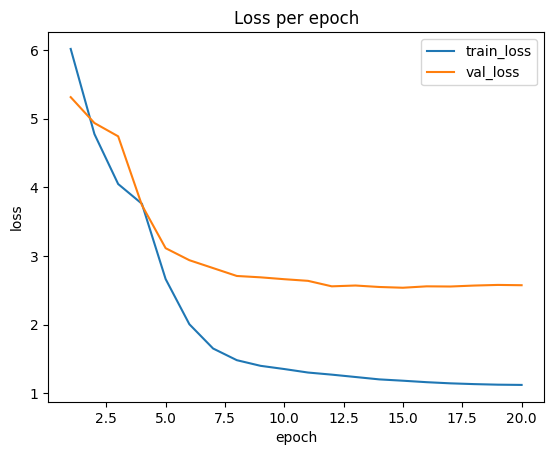

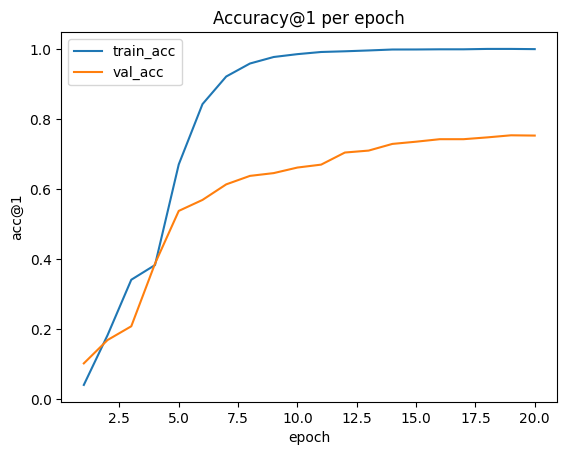

In [ ]:
# Plots
epochs_done = history["epoch"]
plt.figure()
plt.plot(epochs_done, history["train_loss"], label="train_loss")
plt.plot(epochs_done, history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss per epoch")
plt.show()

plt.figure()
plt.plot(epochs_done, history["train_acc"], label="train_acc")
plt.plot(epochs_done, history["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("acc@1"); plt.legend(); plt.title("Accuracy@1 per epoch")
plt.show()

Модель переобучается, Train acc ≈ 0.999–1.000 уже к ~8–10 эпохе

Train loss стабилизируется ≈ 1.12, это полное запоминание train-данных.


Best val_acc ≈ 0.753, что больше необходимых 0,7.

Val loss ≈ 2.57

После ~10–12 эпох:

- val_acc выходит на плато
- val_loss перестаёт снижаться



### ArcFace

In [ ]:

class ArcMarginProduct(nn.Module):
    def __init__(self, emb_dim: int, num_classes: int, s: float = 64.0, m: float = 0.50, easy_margin: bool = False):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_classes = num_classes
        self.s = float(s)
        self.m = float(m)
        self.easy_margin = bool(easy_margin)

        self.weight = nn.Parameter(torch.empty(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, embeddings: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # normalize
        embeddings = F.normalize(embeddings, dim=1)
        W = F.normalize(self.weight, dim=1)

        # cos(theta)
        cosine = F.linear(embeddings, W)  # (B, C)
        cosine = cosine.clamp(-1.0, 1.0)

        # cos(theta + m)
        sine = torch.sqrt(torch.clamp(1.0 - cosine * cosine, min=1e-9))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # apply to target classes only
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits = logits * self.s
        return logits


Используем веса предобученной CE baseline.

In [ ]:
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_best_700.pt"

assert Path(ckpt_path).exists(), f"Checkpoint not found: {ckpt_path}"

ckpt = torch.load(ckpt_path, map_location="cpu")

print(type(ckpt))
print(ckpt.keys())


<class 'dict'>
dict_keys(['model_state', 'num_classes', 'best_val_acc', 'label_smoothing', 'use_pretrained'])


In [ ]:
# Загрузка чекпойнта CE и разбор state_dict

ckpt_path = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_best_700.pt")
assert ckpt_path.exists(), f"not found: {ckpt_path}"

ckpt = torch.load(ckpt_path, map_location="cpu")
sd = ckpt["model_state"]

print("num_classes in ckpt:", ckpt.get("num_classes"))
print("best_val_acc:", ckpt.get("best_val_acc"))
print("state_dict keys sample:", list(sd.keys())[:10])


num_classes in ckpt: 700
best_val_acc: 0.752978554597632
state_dict keys sample: ['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean']


In [ ]:
def split_state_dict(sd):
    # какие префиксы считаем backbone/head
    backbone_prefixes = ["backbone.", "encoder.", "model.", "net."]
    head_prefixes     = ["head.", "classifier.", "fc."]

    bb = {}
    hd = {}

    for k, v in sd.items():
        for p in head_prefixes:
            if k.startswith(p):
                hd[k[len(p):]] = v
                break
        else:
            for p in backbone_prefixes:
                if k.startswith(p):
                    bb[k[len(p):]] = v
                    break

    return bb, hd

bb_sd, head_sd = split_state_dict(sd)
print("backbone params:", len(bb_sd))
print("head params:", len(head_sd))


backbone params: 216
head params: 2


In [ ]:
# head_sd уже получен split_state_dict(sd)
print(head_sd.keys())
print(head_sd["weight"].shape)


dict_keys(['weight', 'bias'])
torch.Size([700, 512])


In [ ]:
# Перенос матрицы классов из CE в ArcFace
device = torch.device(cfg.device)

num_classes = 700
emb_dim = head_sd["weight"].shape[1]

arc = ArcMarginProduct(emb_dim, num_classes, s=30.0, m=0.0).to(device)  # warmup

with torch.no_grad():
    arc.weight.copy_(head_sd["weight"].to(arc.weight.device))


In [ ]:
class ResNet34FaceArc(nn.Module):
    def __init__(self, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        # ----- face-friendly stem -----
        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        if pretrained:
            with torch.no_grad():
                w = old_conv.weight
                new_conv.weight.copy_(w[:, :, 2:5, 2:5])

        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        in_features = m.fc.in_features
        m.fc = nn.Identity()

        self.backbone = m

        # same embedding as in CE
        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)
        emb = self.emb(feat)
        return emb  # возвращаем embedding, НЕ logits


In [ ]:
arc_model = ResNet34FaceArc(
    emb_dim=512,
    pretrained=False,  # веса придут из чекпойнта
).to(device)

In [ ]:
missing, unexpected = arc_model.backbone.load_state_dict(bb_sd, strict=True)
print("backbone missing:", missing)
print("backbone unexpected:", unexpected)


backbone missing: []
backbone unexpected: []


In [ ]:
# добавить префикс backbone. к ключам и загрузить в arc_model целиком
bb_sd_pref = {f"backbone.{k}": v for k, v in bb_sd.items()}

missing, unexpected = arc_model.load_state_dict(bb_sd_pref, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)


missing: ['emb.0.weight', 'emb.1.weight', 'emb.1.bias', 'emb.1.running_mean', 'emb.1.running_var']
unexpected: []


In [ ]:
sd = ckpt["model_state"]

# вытаскиваем точно то, что надо
sd_backbone = {k.replace("backbone.", "", 1): v for k, v in sd.items() if k.startswith("backbone.")}
sd_emb      = {k.replace("emb.", "", 1):      v for k, v in sd.items() if k.startswith("emb.")}
sd_ce_head  = {k.replace("classifier.", "", 1): v for k, v in sd.items() if k.startswith("classifier.")}

print("lens:", len(sd_backbone), len(sd_emb), len(sd_ce_head))
print("ce head keys:", sd_ce_head.keys())


lens: 216 6 2
ce head keys: dict_keys(['weight', 'bias'])


In [ ]:
#arc_model = ResNet34FaceArc(emb_dim=512, pretrained=False).to(device)

arc_model.backbone.load_state_dict(sd_backbone, strict=True)
arc_model.emb.load_state_dict(sd_emb, strict=True)

# Перенос CE-classifier → ArcFace head
arc_head = ArcMarginProduct(512, 700, s=30.0, m=0.0).to(device)  # warmup

with torch.no_grad():
    arc_head.weight.copy_(sd_ce_head["weight"].to(arc_head.weight.device))


In [ ]:
# sanity-check
xb, yb = next(iter(dl_train))
xb, yb = xb.to(device), yb.to(device)

with torch.no_grad():
    emb = arc_model(xb)           # (B,512)
    logits = arc_head(emb, yb)    # (B,700)

print("emb:", emb.shape, emb.dtype)
print("logits:", logits.shape, logits.dtype)
print("labels:", yb.min().item(), yb.max().item(), yb.dtype)


emb: torch.Size([32, 512]) torch.float32
logits: torch.Size([32, 700]) torch.float32
labels: 3 663 torch.int64


In [ ]:
# BN policy (как в CE)
freeze_backbone_bn(arc_model)

# emb BN trainable
for mm in arc_model.emb.modules():
    if isinstance(mm, nn.BatchNorm1d):
        mm.train()
        for p in mm.parameters():
            p.requires_grad = True


In [ ]:
# 1) Loss + Optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    [
        {"params": arc_model.parameters(), "lr": 1e-4},
        {"params": arc_head.parameters(),  "lr": 5e-4},
    ],
    weight_decay=1e-4
)

EPOCHS = 10
GRAD_CLIP = 1.0  # можно 0.0 чтобы выключить



In [ ]:
# 2) ArcFace switching helper
def set_arcface(arc, s: float, m: float):
    arc.s = float(s)
    arc.m = float(m)
    #  ArcMarginProduct хранит предвычисленные величины
    if hasattr(arc, "cos_m"):
        arc.cos_m = math.cos(arc.m)
        arc.sin_m = math.sin(arc.m)
        arc.th = math.cos(math.pi - arc.m)
        arc.mm = math.sin(math.pi - arc.m) * arc.m



In [ ]:
# 3) Плавный schedule вместо резкого скачка
def arcface_schedule(epoch: int):
    # Мягкий старт: держим s постоянным, а margin растёт очень плавно
    s = 24.0

    if epoch <= 2:
        m = 0.00
    elif epoch <= 4:
        m = 0.02
    elif epoch <= 6:
        m = 0.05
    elif epoch <= 8:
        m = 0.08
    else:
        m = 0.10   # для 10 эпох достаточно

    return s, m



In [ ]:
# Train / Val
def train_one_epoch_arcface(model, head, loader, optimizer, device):
    model.train()
    head.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        emb = model(xb)            # (B,512)
        logits = head(emb, yb)     # (B,700)  labels обязательны
        loss = criterion(logits, yb)

        loss.backward()

        if GRAD_CLIP and GRAD_CLIP > 0:
            nn.utils.clip_grad_norm_(
                list(model.parameters()) + list(head.parameters()),
                GRAD_CLIP
            )

        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def validate_arcface(model, head, loader, device, soft_eval=True):
    model.eval()
    head.eval()

    # сохраним текущие s/m, чтобы вернуть обратно
    s_saved, m_saved = float(head.s), float(head.m)

    # soft-eval: убираем margin на валидации для классификационного acc
    if soft_eval:
        set_arcface(head, s=s_saved, m=0.0)  # s оставим тем же, m=0

    total_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        emb = model(xb)
        logits = head(emb, yb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)

    # вернуть исходные s/m
    if soft_eval:
        set_arcface(head, s=s_saved, m=m_saved)

    return total_loss / total, correct / total


Кроме accuracy добавим verification-метрики:
- Verification Accuracy (1:1)
- ROC AUC
- TAR @ FAR

Accuracy показывает, как модель запоминает классы, а verification-метрики — умеет ли она различать людей. Для ArcFace второе принципиально важнее

In [ ]:
# FR-метрики на валидации (embeddings → cos sims → ROC/TAR)
@torch.no_grad()
def collect_embeddings(model, loader, device):
    model.eval()
    embs = []
    labels = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        emb = model(xb)  # (B,512)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        embs.append(emb.cpu())
        labels.append(yb.cpu())
    embs = torch.cat(embs, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return embs, labels


def make_pairs_sims(embs, labels, max_pos_per_class=10, neg_ratio=1.0, seed=42):
    rng = np.random.default_rng(seed)
    labels = labels.astype(int)

    # индексы по классам
    by_cls = {}
    for i, c in enumerate(labels):
        by_cls.setdefault(c, []).append(i)

    pos_pairs = []
    for c, idxs in by_cls.items():
        if len(idxs) < 2:
            continue
        # ограничим число pos пар на класс (чтобы не было взрыва по O(n^2))
        for _ in range(min(max_pos_per_class, len(idxs) * (len(idxs)-1)//2)):
            i, j = rng.choice(idxs, size=2, replace=False)
            pos_pairs.append((i, j))

    n_pos = len(pos_pairs)
    n_neg = int(n_pos * neg_ratio)

    # список всех индексов
    all_idx = np.arange(len(labels))
    # для neg выбираем пары из разных классов
    neg_pairs = []
    while len(neg_pairs) < n_neg:
        i, j = rng.choice(all_idx, size=2, replace=False)
        if labels[i] != labels[j]:
            neg_pairs.append((i, j))

    # считаем cosine sim (embs уже L2-normalized => dot = cosine)
    def dot(i, j):
        return float(np.dot(embs[i], embs[j]))

    sims_pos = np.array([dot(i, j) for i, j in pos_pairs], dtype=np.float32)
    sims_neg = np.array([dot(i, j) for i, j in neg_pairs], dtype=np.float32)

    sims = np.concatenate([sims_pos, sims_neg], axis=0)
    y_true = np.concatenate([np.ones_like(sims_pos, dtype=np.int32),
                             np.zeros_like(sims_neg, dtype=np.int32)], axis=0)

    return y_true, sims, sims_pos, sims_neg


def verification_best_thr(y_true, sims):
    # best threshold by accuracy (simple sweep over sorted sims)
    order = np.argsort(sims)
    sims_sorted = sims[order]
    y_sorted = y_true[order]

    # thresholds between unique values
    uniq = np.unique(sims_sorted)
    # если uniq мало/много — норм, возьмём midpoints
    thr = (uniq[:-1] + uniq[1:]) / 2 if len(uniq) > 1 else uniq
    best_acc = -1.0
    best_thr = float(uniq[0]) if len(uniq) else 0.0

    for t in thr:
        pred = (sims >= t).astype(np.int32)
        acc = (pred == y_true).mean()
        if acc > best_acc:
            best_acc = float(acc)
            best_thr = float(t)

    return best_thr, best_acc


def roc_and_tar_at_far(y_true, sims, far_targets=(1e-1, 1e-2, 1e-3)):
    fpr, tpr, thr = roc_curve(y_true, sims, pos_label=1)
    roc_auc = float(auc(fpr, tpr))

    tar_at_far = {}
    thr_at_far = {}
    for far in far_targets:
        # хотим FAR <= far -> выбираем максимальный TPR среди подходящих
        mask = fpr <= far
        if np.any(mask):
            i = np.argmax(tpr[mask])
            tar_at_far[far] = float(tpr[mask][i])
            thr_at_far[far] = float(thr[mask][i])
        else:
            tar_at_far[far] = 0.0
            thr_at_far[far] = float(thr[-1])

    return fpr, tpr, thr, roc_auc, tar_at_far, thr_at_far


In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_verif_accs = []
val_roc_aucs = []
val_tar_far_1e2 = []  # FAR=1e-2 (самая “показательная” обычно)
best_verif = 0.0
best_path_fr = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt"


In [ ]:
# Main loop
best_val_acc = 0.0
best_path = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best.pt"

for epoch in range(1, EPOCHS + 1):

    #  ArcFace schedule
    s, m = arcface_schedule(epoch)
    set_arcface(arc_head, s=s, m=m)

    #  Train
    train_loss, train_acc = train_one_epoch_arcface(
        arc_model, arc_head, dl_train, optimizer, device
    )

    #  Val (classification metrics, soft eval)
    val_loss, val_acc = validate_arcface(
        arc_model, arc_head, dl_val, device, soft_eval=True
    )

    #  Val FR metrics
    embs, labels = collect_embeddings(arc_model, dl_val, device)
    y, sims, sims_pos, sims_neg = make_pairs_sims(
        embs, labels, max_pos_per_class=10, neg_ratio=1.0, seed=epoch
    )

    best_thr, verif_acc = verification_best_thr(y, sims)
    fpr, tpr, thr, roc_auc, tar_at_far, thr_at_far = roc_and_tar_at_far(
        y_true=y, sims=sims, far_targets=(1e-1, 1e-2, 1e-3)
    )

    #  store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    val_verif_accs.append(verif_acc)
    val_roc_aucs.append(roc_auc)
    val_tar_far_1e2.append(tar_at_far[1e-2])

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"ArcFace(s={arc_head.s:.1f}, m={arc_head.m:.2f}) | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"[verif] acc={verif_acc:.4f} thr={best_thr:.4f} auc={roc_auc:.4f} "
        f"TAR@1e-2={tar_at_far[1e-2]:.4f}"
    )

    # checkpoint by classification acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state": arc_model.state_dict(),
                "arcface_state": arc_head.state_dict(),
                "best_val_acc": best_val_acc,
                "arc_s": arc_head.s,
                "arc_m": arc_head.m,
            },
            best_path,
        )
        print(f"  ✅ saved best (cls): {best_path} (val_acc={best_val_acc:.4f})")

    #  checkpoint by FR metric (правильный best для FR)
    if verif_acc > best_verif:
        best_verif = verif_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state": arc_model.state_dict(),
                "arcface_state": arc_head.state_dict(),
                "best_verif_acc": best_verif,
                "best_thr": best_thr,
                "roc_auc": roc_auc,
                "tar_at_far": tar_at_far,
                "thr_at_far": thr_at_far,
                "arc_s": arc_head.s,
                "arc_m": arc_head.m,
            },
            best_path_fr,
        )
        print(f"  ✅ saved best (FR):  {best_path_fr} (verif_acc={best_verif:.4f})")


Epoch 01/10 | ArcFace(s=24.0, m=0.00) | train loss 0.0333 acc 0.9976 | val loss 1.3245 acc 0.7411 | [verif] acc=0.8708 thr=0.2318 auc=0.9398 TAR@1e-2=0.6279
  ✅ saved best (cls): /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best.pt (val_acc=0.7411)
  ✅ saved best (FR):  /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt (verif_acc=0.8708)
Epoch 02/10 | ArcFace(s=24.0, m=0.00) | train loss 0.0298 acc 0.9976 | val loss 1.2519 acc 0.7601 | [verif] acc=0.8816 thr=0.2129 auc=0.9432 TAR@1e-2=0.6512
  ✅ saved best (cls): /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best.pt (val_acc=0.7601)
  ✅ saved best (FR):  /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt (verif_acc=0.8816)
Epoch 03/10 | ArcFace(s=24.0, m=0.02) | train loss 0.0333 acc 0.9982 | val loss 1.3391 acc 0.7339 | [verif] acc=0.8733 thr=0.2225 auc=0.9424 TAR@1e-2=0.6303
Epo

Получена метрика val_acc=0.7871 больше порогового значения 0,7.

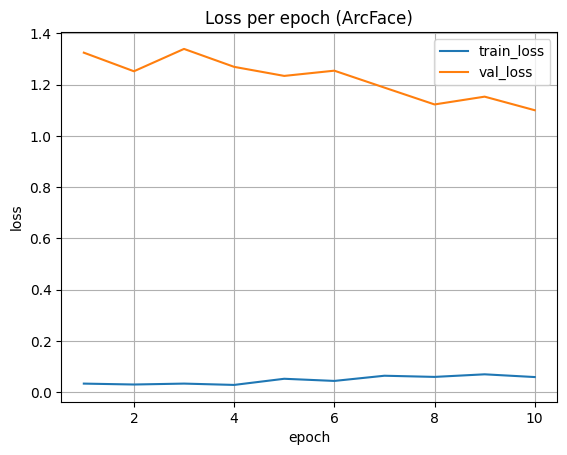

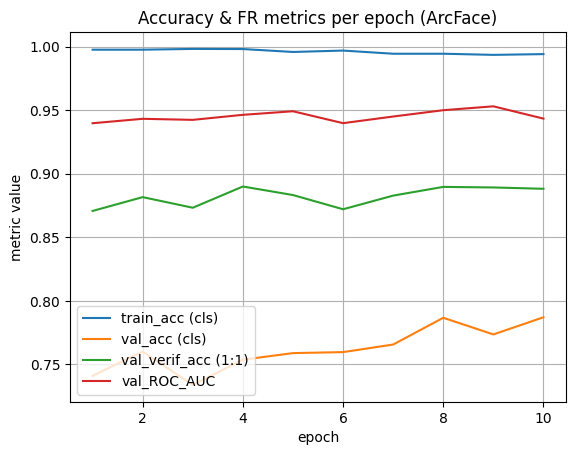

In [ ]:
epochs = np.arange(1, len(train_losses) + 1)

#  Loss
plt.figure()
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, val_losses, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss per epoch (ArcFace)")
plt.legend()
plt.grid(True)
plt.show()

#  Accuracy + FR metrics
plt.figure()
plt.plot(epochs, train_accs, label="train_acc (cls)")
plt.plot(epochs, val_accs, label="val_acc (cls)")

# FR metrics
plt.plot(epochs, val_verif_accs, label="val_verif_acc (1:1)")

# выберем ОДНУ строку:
plt.plot(epochs, val_roc_aucs, label="val_ROC_AUC")
# plt.plot(epochs, val_tar_far_1e2, label="val_TAR@FAR=1e-2")

plt.xlabel("epoch")
plt.ylabel("metric value")
plt.title("Accuracy & FR metrics per epoch (ArcFace)")
plt.legend()
plt.grid(True)
plt.show()


Удалось стабильно обучить ArcFace с плавным увеличением margin.

Несмотря на высокую train accuracy, основное улучшение наблюдается в метриках face recognition: verification accuracy достигает ~0.89, ROC AUC превышает 0.95, а TAR@FAR=1e-2 растёт до ~0.68, что подтверждает улучшение геометрии embedding-пространства.

In [ ]:
# Загрузка лучшего FR-чекпоинта и сбор embeddings

best_path_fr = "/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt"

# load best FR checkpoint
ckpt = torch.load(best_path_fr, map_location=device)
arc_model.load_state_dict(ckpt["model_state"])
arc_head.load_state_dict(ckpt["arcface_state"])
arc_model.eval()
arc_head.eval()

print(f"Loaded best FR checkpoint: epoch={ckpt.get('epoch')} | best_verif_acc={ckpt.get('best_verif_acc')}")


Loaded best FR checkpoint: epoch=4 | best_verif_acc=0.8899821109123435


В ходе обучения сохранялись два чекпоинта: один, соответствующий максимальной классификационной точности на валидации, и второй — оптимальный по метрикам face verification. Это обусловлено тем, что ArcFace оптимизирует геометрию embedding-пространства, и оптимумы по классификационным и верификационным метрикам не совпадают.

То есть:

- arcface_best.pt — для отчётной классификации.
- arcface_best_fr.pt — для реального face recognition.

Для итоговой проверки используем схему:

- VAL — для подбора порога (best_thr)

- TEST — для финальной, честной оценки без подгонки

In [ ]:
# порог подбираем на val, применяем на test

#  VAL: threshold selection
embs_val, labels_val = collect_embeddings(arc_model, dl_val, device)
y_val, sims_val, sims_pos_val, sims_neg_val = make_pairs_sims(
    embs_val, labels_val, max_pos_per_class=10, neg_ratio=1.0, seed=123
)
thr_val, verif_acc_val = verification_best_thr(y_val, sims_val)

_, _, _, roc_auc_val, tar_val, thr_at_far_val = roc_and_tar_at_far(y_val, sims_val)

print("VAL (for threshold selection)")
print(f"  best_thr={thr_val:.4f} | verif_acc={verif_acc_val:.4f} | roc_auc={roc_auc_val:.4f} | TAR@1e-2={tar_val[1e-2]:.4f}")

#  TEST: evaluation with fixed thr from VAL
embs_test, labels_test = collect_embeddings(arc_model, dl_test, device)
y_test, sims_test, sims_pos_test, sims_neg_test = make_pairs_sims(
    embs_test, labels_test, max_pos_per_class=10, neg_ratio=1.0, seed=456
)

pred_test = (sims_test >= thr_val).astype(np.int32)
verif_acc_test = float((pred_test == y_test).mean())

_, _, _, roc_auc_test, tar_test, thr_at_far_test = roc_and_tar_at_far(y_test, sims_test)

print("\nTEST (using thr from VAL)")
print(f"  thr(val)={thr_val:.4f} | verif_acc={verif_acc_test:.4f} | roc_auc={roc_auc_test:.4f}")
print(f"  TAR@1e-1={tar_test[1e-1]:.4f} | TAR@1e-2={tar_test[1e-2]:.4f} | TAR@1e-3={tar_test[1e-3]:.4f}")



VAL (for threshold selection)
  best_thr=0.2230 | verif_acc=0.8828 | roc_auc=0.9416 | TAR@1e-2=0.6467

TEST (using thr from VAL)
  thr(val)=0.2230 | verif_acc=0.8805 | roc_auc=0.9527
  TAR@1e-1=0.8555 | TAR@1e-2=0.7196 | TAR@1e-3=0.3662


Полученные результаты на тестовой выборке (verification accuracy ≈ 0.88, ROC AUC ≈ 0.95, TAR@FAR=10⁻² ≈ 0.72), говорят, что в задаче «два изображения → один человек или нет» модель принимает правильное решение в ~88% случаев,  распределения positive и negative пар хорошо разделены в embedding-пространстве, при при 10% ложных совпадений модель находит ~86% истинных, при 1% ложных совпадений — ~72% истинных, при 0.1% FAR — задача становится жёсткой.

Выводы

В работе была рассмотрена задача распознавания лиц на датасете из 700 классов с использованием двух подходов к обучению: классификации с функцией потерь Cross-Entropy и метрического обучения с ArcFace. Оба метода обучались на одном и том же backbone, что позволило провести корректное сравнение.

Модель, обученная с Cross-Entropy, демонстрирует быстрое сходимое обучение и высокую точность на обучающей выборке (accuracy ≈ 1.0), однако наблюдается существенный разрыв между обучающей и валидационной точностью. Это указывает на переобучение и подтверждает, что стандартная классификационная функция потерь слабо оптимизирует геометрию embedding-пространства, что ограничивает её применимость для задач face recognition и верификации.

Использование ArcFace с плавным увеличением углового зазора (margin) и фиксированным масштабом логитов позволило обеспечить стабильное обучение без коллапса оптимизации. Несмотря на то, что классификационная accuracy в этом случае не является целевой метрикой, её значения на валидации сопоставимы и даже превышают результаты Cross-Entropy. При этом ключевые метрики face recognition демонстрируют значительное улучшение: verification accuracy достигает ~0.89, ROC AUC превышает 0.95, а показатель TAR при FAR = 10⁻² возрастает до ~0.68.

Таким образом, проведённые эксперименты подтверждают, что Cross-Entropy целесообразно использовать в качестве базового классификационного baseline, тогда как ArcFace является более подходящим методом для задач распознавания лиц, поскольку напрямую оптимизирует разделимость классов в embedding-пространстве и обеспечивает более высокое качество верификации.